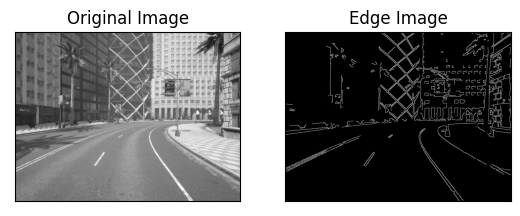

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

image = cv2.imread("D:/SelfDrivingImages/output/004610.png", cv2.IMREAD_GRAYSCALE)
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
edges = cv2.Canny(blurred_image, threshold1=100, threshold2=200)
plt.subplot(121), plt.imshow(image, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(edges, cmap='gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()



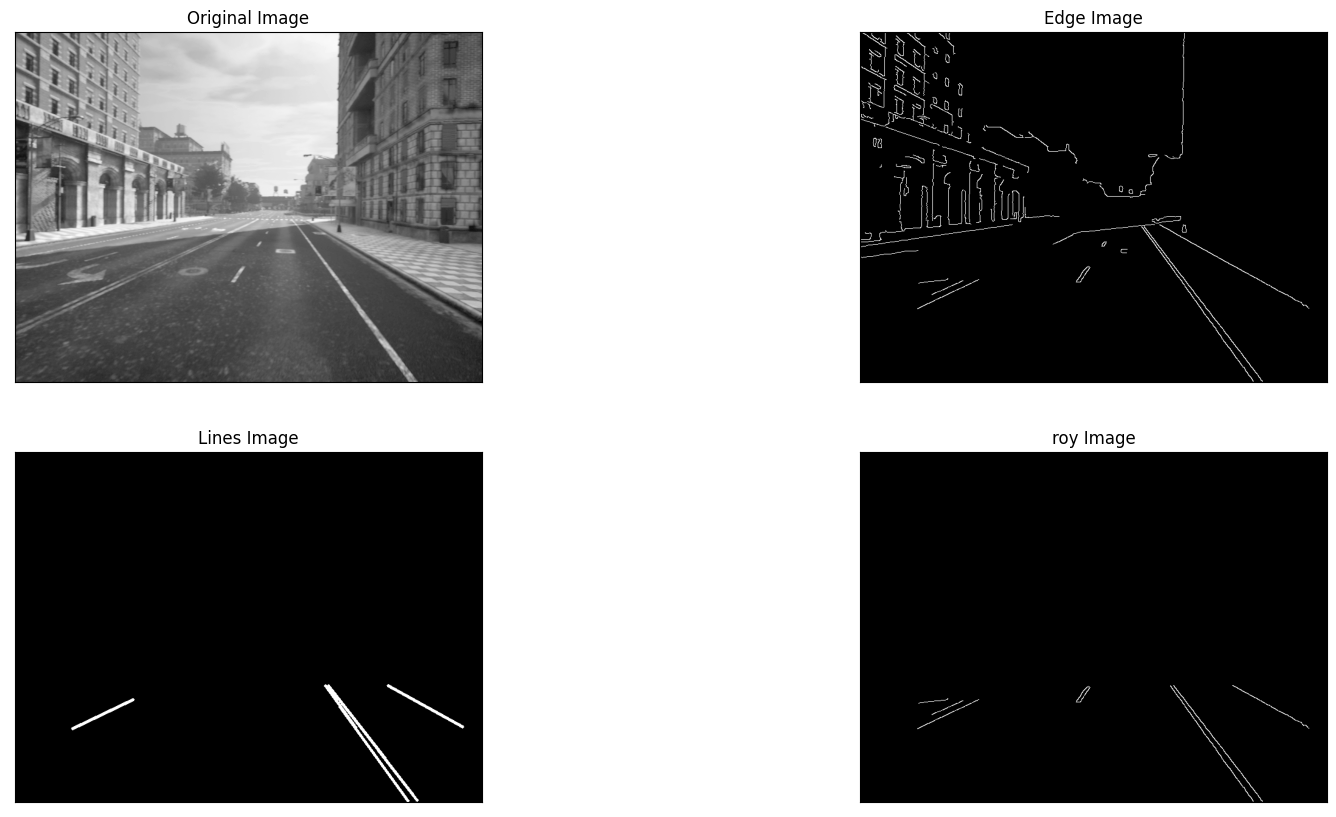

In [35]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Read the image from the provided path
image_path = "D:/SelfDrivingImages/output/004938.png"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur
blurred_image = cv2.GaussianBlur(image, (5, 5), 0)

# Perform edge detection
edges = cv2.Canny(blurred_image, threshold1=100, threshold2=200)

# Define the region of interest (ROI)
def region_of_interest(img):
    height, width = img.shape
    mask = np.zeros_like(img)
    
    # Define a polygon for the mask, here a trapezoid
    polygon = np.array([[
        (0, height * 2 / 3),
        (width, height * 2 / 3),
        (width, height),
        (0, height),
    ]], np.int32)
    
    # Fill that polygon with white color
    cv2.fillPoly(mask, polygon, 255)
    
    # Bitwise AND between canny image and mask to get ROI
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Apply ROI on the edge image
roi_image = region_of_interest(edges)

# Perform Hough Transform to find lanes
lines = cv2.HoughLinesP(
    roi_image,
    rho=1,              # Distance resolution in pixels
    theta=np.pi/180,    # Angle resolution in radians
    threshold=50,       # Min. number of intersecting points to detect a line
    lines=np.array([]), # Vector to return the start and end of lines
    minLineLength=5,    # Min. number of points to form a line
    maxLineGap=10       # Max. gap between lines to consider them as single line
)

# Create an image to draw the lines
lines_image = np.zeros_like(image)

# Draw lines on the image
if lines is not None:
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(lines_image, (x1, y1), (x2, y2), (255, 0, 0), 3)

# Display the result
plt.figure(figsize=(20, 10))
plt.subplot(221), plt.imshow(image, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(edges, cmap='gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(lines_image, cmap='gray')
plt.title('Lines Image'), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(roi_image, cmap="gray")
plt.title('roy Image'), plt.xticks([]), plt.yticks([])
plt.show()


In [36]:
import numpy as np
import carla

# Function to calculate the steering angle from the detected lines
def calculate_steering_angle(lines, image_shape):
    # If no lines were detected, return a default steering angle
    if lines is None:
        return 0.0

    # Initialize lists to store the slopes and intercepts of the lines
    slopes = []
    intercepts = []

    # Iterate over the lines
    for line in lines:
        for x1, y1, x2, y2 in line:
            # Calculate the slope and intercept for each line
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - slope * x1
            slopes.append(slope)
            intercepts.append(intercept)

    # Calculate the average slope and intercept
    avg_slope = np.mean(slopes)
    avg_intercept = np.mean(intercepts)

    # Calculate the steering angle
    # For simplicity, let's assume that a positive slope requires a right turn
    # and a negative slope requires a left turn.
    # You will need to calibrate this based on your simulator setup and test.
    mid_x = image_shape[1] / 2
    mid_y = image_shape[0]
    lane_midpoint_x = (mid_y - avg_intercept) / avg_slope if avg_slope != 0 else mid_x
    direction = np.arctan((lane_midpoint_x - mid_x) / mid_y)
    steering_angle = direction / np.pi

    return steering_angle

# Calculate the steering angle from the Hough lines
steering_angle = calculate_steering_angle(lines, image.shape)

print(steering_angle)
# Apply the control to the vehicle in the CARLA simulator
#vehicle.apply_control(carla.VehicleControl(throttle=0.2, steer=steering_angle, brake=0.0, reverse=False))


0.17662867703556953


In [1]:
import cv2
import numpy as np

# Load the image
image = cv2.imread("D:/SelfDrivingImages/output/004938.png")

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Canny Edge Detection
edges = cv2.Canny(blur, 50, 150)

# Optional: Define a region of interest (ROI)
# For example, you might want to focus on the lower part of the image
# where the road usually is. This step is highly dependent on your image.
height, width = edges.shape
mask = np.zeros_like(edges)
polygon = np.array([[
    (0, height),
    (width, height),
    (width, height // 2),
    (0, height // 2)
]], np.int32)
cv2.fillPoly(mask, polygon, 255)
cropped_edges = cv2.bitwise_and(edges, mask)

# Optional: Hough Line Transform to find lines
lines = cv2.HoughLinesP(cropped_edges, 1, np.pi/180, 50, minLineLength=100, maxLineGap=50)

# Draw the lines on the image (if any)
line_image = np.copy(image)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(line_image, (x1, y1), (x2, y2), (0, 255, 0), 5)

# Display the result
cv2.imshow('Edges', edges)
cv2.imshow('Cropped Edges', cropped_edges)
cv2.imshow('Road with Lines', line_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [1]:
import cv2
import numpy as np

# Read the image
image = cv2.imread("D:/SelfDrivingImages/output/004938.png")

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Canny edge detection
edges = cv2.Canny(blur, 50, 150)

# Optional: Define a region of interest (ROI)
# Assuming you want to mask the upper part of the image
height, width = edges.shape
mask = np.zeros_like(edges)
polygon = np.array([[
    (0, height),
    (width, height),
    (width, height // 2),
    (0, height // 2)
]], np.int32)
cv2.fillPoly(mask, polygon, 255)

# Bitwise operation to keep only the ROI
masked_edges = cv2.bitwise_and(edges, mask)

# Optional: Hough Line Transform
lines = cv2.HoughLinesP(masked_edges, 1, np.pi / 180, threshold=50, minLineLength=100, maxLineGap=50)

# Draw lines on the image (if any)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 3)

# Display the result
cv2.imshow('Road Edges', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


: 